In [1]:
import os
os.chdir('/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves')

In [2]:
from help_funcs import * 
# from eofs.xarray import Eof
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import importlib
import xarray as xr
# importlib.reload(xr)
import seaborn as sns
import pandas as pd
import cmocean.cm as cm
import netCDF4 as nc
from pathlib import Path
from natsort import natsorted
import matplotlib.pyplot as plt
import gsw

In [3]:
from multiprocessing import Pool
import os 
import multiprocessing
from os.path import exists

In [4]:
sns.set_context("notebook")

In [5]:
def rm_each_month_mean(ds):
    xy_mean = ds["thetao"].mean(dim=['latitude', 'longitude'], skipna=True)
    z_mean = xy_mean.mean(dim = "depth")
    return xy_mean - z_mean
def remove_seasonal(ds):
    climatology = ds.groupby("time.month").mean("time")
    anomalies = ds.groupby("time.month") - climatology
    return anomalies.drop("month")

In [6]:
import gsw

def sigma0_from_SP_and_pt0(z, SP, pt0, lon = 0, lat = 30):
    p = gsw.p_from_z(-np.abs(z), lat)
    SA = gsw.SA_from_SP(SP, p, lon, lat)
    CT = gsw.CT_from_pt(SA,pt0)
    sigma0 = gsw.sigma0(SA,CT)
    return sigma0

In [7]:
%time
from pathlib import Path
from natsort import natsorted
GLORYS_dir = r"/vortexfs1/home/anthony.meza/GLORYS_data" 
results = [str(result) for result in list(Path(GLORYS_dir).rglob("*.[nN][cC]"))] #get all files
results = natsorted(results) #sort all files 

years = natsorted(list(set([result[41:45] for result in results])))
months = natsorted(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'])

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 5.72 µs


### Get NINO 3.4 Index

In [8]:
df = pd.read_csv("nino34.long.csv", index_col=0)
dates_df = df.astype("datetime64[D]")
for year in range(0, len(df.index)):
    for month in range(1, len(df.columns)+1):
        dates_df.iloc[year, month - 1] = np.datetime64(pd.Timestamp(df.index[year], month, 15), "D")
NINO34_ds = xr.DataArray(
            data=df.values.flatten(),
            dims=["time"],
            coords=dict(time=dates_df.values.flatten()))
NINO34 = NINO34_ds.sel(time = slice("1993", None))

### Doing an EOF on this time period, see if a wave pattern appears along coastline around the time of 97 Nino event. EOF will be done on the 100m temperature 

In [9]:
def read_ds_ocn(fname): #very little memory footprint, 1 day = 500kib
    with xr.open_dataset(fname) as ds:
        ds_new = ds[["thetao", "so"]].sel(depth = 75, method = "nearest")
        ds_new = ds_new.sel(longitude = slice(-124, -105), latitude = slice(25, 40) )
        return ds_new

In [10]:
%%time 
n_cores = multiprocessing.cpu_count() - 5
NINO_97 = []
for year in ["2001", "2002", "2003"]:
    print(year)
    files = np.empty(0, dtype = str)
    for month in months:
        file_path = GLORYS_dir + "/" + year + "/" + month
        file_list = natsorted([str(result) for result in list(Path(GLORYS_dir + "/" + year + "/" + month + "/").rglob("*.[nN][cC]"))])
        files = np.concatenate([files, file_list])
    files = natsorted([str(f) for f in files])
    if __name__ == '__main__':
        with Pool(n_cores) as p:
            datasets = p.map(read_ds_ocn, files)
    datasets = [d for d in datasets]
    NINO_97 = NINO_97 + datasets #about 50 gigs of data!! 
    


2001
2002
2003
CPU times: user 702 ms, sys: 760 ms, total: 1.46 s
Wall time: 11.4 s


In [11]:
%%time 
NINO_97_ds = xr.concat(NINO_97, dim = "time", data_vars = "minimal", coords = "minimal")
NINO_97_ds = NINO_97_ds.sortby("time")

CPU times: user 4.07 s, sys: 1.88 s, total: 5.95 s
Wall time: 6min 15s


In [12]:
z = -NINO_97_ds.depth
SP = NINO_97_ds.so
pt0 = NINO_97_ds.thetao
sigma0_NINO97 = sigma0_from_SP_and_pt0(z, SP, pt0)
sigma0_NINO97 = sigma0_NINO97.rename("sigma0")

In [13]:
GLORYS_ds_clim = xr.open_dataset("GLORYS_processed/GLORYS_Data.nc").sel(longitude = slice(-124, -105), latitude = slice(25, 40))
GLORYS_ds_clim = GLORYS_ds_clim.isel(time = slice(0,312)) #data corrupted beyond 312
GLORYS_ds_clim = GLORYS_ds_clim.sel(depth = sigma0_NINO97.depth)


In [14]:
nt = len(GLORYS_ds_clim.time)
# nd = len(GLORYS_ds_clim.depth)
nlat = len(GLORYS_ds_clim.latitude)
nlon = len(GLORYS_ds_clim.longitude)
depth_grid = np.zeros((nt, nlat, nlon))
lat_grid = np.zeros((nt, nlat, nlon))
lon_grid = np.zeros((nt, nlat, nlon))
LONS, LATS = np.meshgrid(GLORYS_ds_clim.longitude, GLORYS_ds_clim.latitude)

for it in range(0, nt):
        depth_grid[it, :, :] = -GLORYS_ds_clim.depth
        lat_grid[it, :, :] = LATS
        lon_grid[it, :, :] = LONS
        
SP = GLORYS_ds_clim.so.values
pt0 = GLORYS_ds_clim.thetao.values
sigma0_climatology = np.nan*GLORYS_ds_clim.thetao.rename("sigma0")
sigma0_climatology.values = sigma0_from_SP_and_pt0(depth_grid, SP, pt0, lon_grid, lat_grid)

In [15]:
sigma0_climatology = sigma0_climatology.groupby("time.month").mean("time")

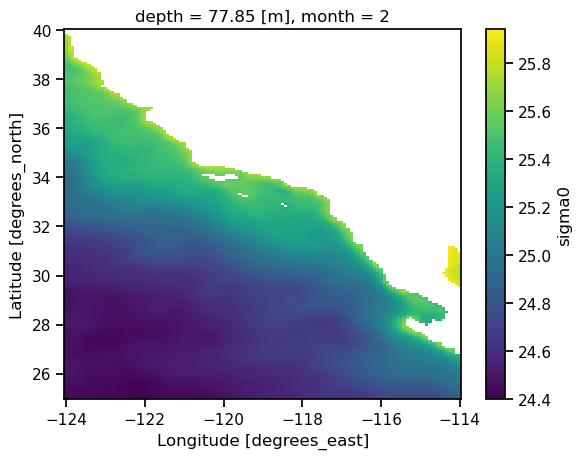

In [16]:
sigma0_climatology.isel( month = 1).plot()

In [18]:
time_slice= slice("2001.5", "2003")
anomalies = sigma0_NINO97.groupby("time.month") - sigma0_climatology
sigma0_NINO97_anom = anomalies.drop("month") 
sigma0_NINO97_anom = sigma0_NINO97_anom.sel(time = time_slice)

In [19]:
# anomalies = sigma0_NINO97.groupby("time.month") - sigma0_climatology.mean(dim = ["latitude", "longitude"])
# sigma0_NINO97_anom = anomalies.drop("month") - anomalies.mean(dim = "time")
# sigma0_NINO97_anom = sigma0_NINO97 - sigma0_NINO97.mean(dim = ["latitude", "longitude", "time"]).values
# sigma0_NINO97_anom = sigma0_NINO97_anom.drop("depth")

In [21]:
#trying to recreate line 90 in California
# y = mx + b 
x0 = -117; y0 = 33
m = ((33 - 31) / (x0 - -125))
b = y0- x0*m 
line = lambda x : m*x + b
xs_C = np.linspace(-123, x0)
ys_C = line(xs_C)

/vortexfs1/home/anthony.meza/.conda/envs/notebook_env/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/vortexfs1/home/anthony.meza/.conda/envs/notebook_env/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
MovieWriter imagemagick unavailable; using Pillow instead.
/vortexfs1/home/anthony.meza/.conda/envs/notebook_env/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/vortexfs1/home/anthony.meza/.conda/envs/notebook_env/lib/python3.10

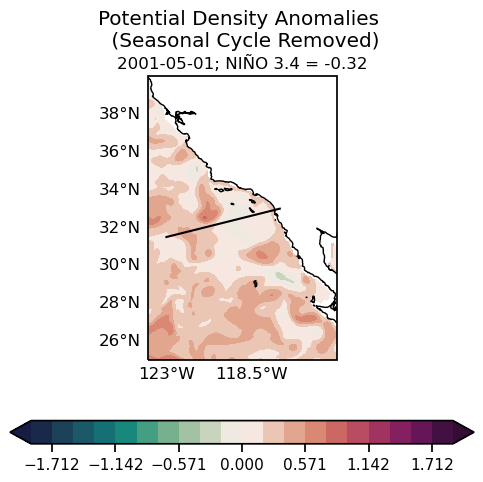

In [22]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

event_name = "02Nino"
NINO34_97 = remove_seasonal(NINO34).interp(time = sigma0_NINO97_anom.time)
NINO34_97 = np.round(NINO34_97, decimals = 2)

fig,ax1 = plt.subplots(figsize = (5, 5),  subplot_kw = {"projection":ccrs.PlateCarree()})

data = sigma0_NINO97_anom.values
times = sigma0_NINO97_anom.time.values
times = pd.to_datetime(times).strftime('%Y-%m-%d')
nt = len(times)


LONS, LATS = np.meshgrid(sigma0_NINO97_anom.longitude, sigma0_NINO97_anom.latitude)
bounds = np.nanmax(np.abs(data))
levels = np.linspace(-bounds, bounds, 21)

cf = ax1.contourf(LONS, LATS, data[0, :, :], 
                  vmin = -bounds, vmax = bounds, levels = levels, 
                  cmap=cm.curl, extend = "both")
ax1.coastlines()
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.0)
gl.xlabels_top = False
gl.ylabels_right = False
fig.colorbar(cf, orientation = "horizontal")
fig.suptitle("Potential Density Anomalies \n (Seasonal Cycle Removed)")
fig.tight_layout()
def animate(i):
    ax1.clear(); 
    fontweight = "normal" if NINO34_97.values[i] < 0.5 else "bold"
    ax1.set_title(times[i] + "; NIÑO 3.4 = " + str(NINO34_97.values[i]), fontweight = fontweight)
    ax1.coastlines()
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.0)
    gl.xlabels_top = False
    gl.ylabels_right = False
    cf = ax1.contourf(LONS, LATS, data[i, :, :], 
                      vmin = -bounds, vmax = bounds, levels = levels, 
                      cmap=cm.curl, extend = "both")
    ax1.plot(xs_C, ys_C, color = "k")
    
anim = FuncAnimation(fig, animate, frames=nt, interval=20, blit=False)
anim.save(event_name + '.gif', writer='imagemagick')